In [62]:
# GAMの実装参考
# https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model

In [63]:
import pandas as pd        
from pygam import LogisticGAM
from pygam import LinearGAM
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import preprocessing

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [64]:
#データ読み込み
from sklearn.datasets import load_boston
boston = load_boston()
df=pd.DataFrame(boston.data, columns=boston.feature_names)

In [65]:
#使用する変数を選択
X = df[['CRIM', 'ZN','RM', 'AGE', 'DIS', 'LSTAT']]
ss = preprocessing.StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X))
X_ss.columns=X.columns
y = boston.target
#y = ytmp

In [66]:
X_ss.head()

,CRIM,ZN,RM,AGE,DIS,LSTAT
0,-0.419782,0.284830,0.413672,-0.120013,0.140214,-1.075562
1,-0.417339,-0.487722,0.194274,0.367166,0.557160,-0.492439
2,-0.417342,-0.487722,1.282714,-0.265812,0.557160,-1.208727
3,-0.416750,-0.487722,1.016303,-0.809889,1.077737,-1.361517
4,-0.412482,-0.487722,1.228577,-0.511180,1.077737,-1.026501


In [67]:
#trainとtestに分ける
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, 
                                                    test_size=0.3, random_state=42)

In [68]:
#GAMを適用
gam = LinearGAM().fit(X_train, y_train)

In [69]:
#実行結果
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     55.6152
Link Function:                     IdentityLink Log Likelihood:                                 -1261.9882
Number of Samples:                          354 AIC:                                             2637.2067
                                                AICc:                                            2659.2179
                                                GCV:                                               18.9356
                                                Scale:                                             13.6695
                                                Pseudo R-Squared:                                   0.8689
Feature Function                  Lam

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


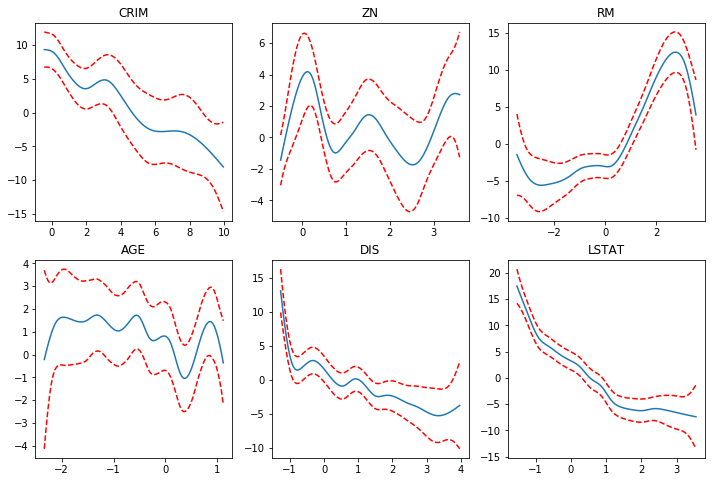

In [70]:
#それぞれのf(x)を図示
plt.figure(figsize=(12,8))
for i in range(X.shape[1]):
    plt.subplot(2,3,i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i],gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1],
                c='r', ls='--')
    plt.title(X.columns[i])
plt.show()

In [71]:
#GAMのRMSEの確認
(((y_test-gam.predict(X_test))**2).sum()/152)**(1/2)

4.115590183354268

In [72]:
#線形回帰の実装（切片あり）
import statsmodels.api as sm
Xols=X_train.copy()
Xols["coef"]=1
mod = sm.OLS(y_train, Xols)
res = mod.fit()

In [73]:
Xols_test=X_test.copy()
Xols_test["coef"]=1
rmse_ols=(((y_test-res.predict(Xols_test))**2).sum()/len(y_test))**(1/2)
print(rmse_ols)

5.261100609131485


In [74]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     126.4
Date:                Sat, 23 Mar 2019   Prob (F-statistic):           3.45e-84
Time:                        10:26:33   Log-Likelihood:                -1089.5
No. Observations:                 354   AIC:                             2193.
Df Residuals:                     347   BIC:                             2220.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -1.4548      0.330     -4.413      0.000      -2.103      -0.806
ZN             1.3501      0.409      3.298      0.001       0.545       2.155
RM             3.2916      0.364      9.055      0.000       2.577       4.007
AGE           -0.6515      0.473     -1.377      0.169      -1.582       0.279
DIS           -2.5610      0.484     -5.290      0.000      -3.513      -1.609
LSTAT         -4.7244      0.442    -10.696      0.000      -5.593      -3.856
coef          22.6128      0.283     80.029      0.000      22.057      23.169
==============================================================================
Omnibus:                      101.900   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.522
Skew:                           1.281   Prob(JB):                     1.25e-71
Kurtosis:                       6.947   Cond. No.                         3.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
#lightgbmの実装
lgbX_train, lgbX_valid, lgby_train, lgby_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
params={
    'random_state' : 1,
    'objective': 'rmse',
    }
dtrain = lgb.Dataset(lgbX_train, label=lgby_train)
dvalid = lgb.Dataset(lgbX_valid, label=lgby_valid)
bst = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dtrain,dvalid],early_stopping_rounds=50,verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	training's rmse: 4.68012	valid_1's rmse: 5.74908
[20]	training's rmse: 3.245	valid_1's rmse: 5.19158
[30]	training's rmse: 2.76589	valid_1's rmse: 5.03246
[40]	training's rmse: 2.47395	valid_1's rmse: 4.95318
[50]	training's rmse: 2.27421	valid_1's rmse: 4.90139
[60]	training's rmse: 2.11987	valid_1's rmse: 4.82788
[70]	training's rmse: 2.00621	valid_1's rmse: 4.80546
[80]	training's rmse: 1.89071	valid_1's rmse: 4.78078
[90]	training's rmse: 1.79848	valid_1's rmse: 4.80035
[100]	training's rmse: 1.70625	valid_1's rmse: 4.80343
[110]	training's rmse: 1.62234	valid_1's rmse: 4.80954
[120]	training's rmse: 1.5466	valid_1's rmse: 4.80223
[130]	training's rmse: 1.48672	valid_1's rmse: 4.80593
Early stopping, best iteration is:
[80]	training's rmse: 1.89071	valid_1's rmse: 4.78078


In [76]:
rmse_lgb=((((y_test-bst.predict(X_test))**2).sum())/len(y_test))**(1/2)
print(rmse_lgb)

3.9503647671653432


In [77]:
#重要度の確認
pd.DataFrame(bst.feature_importance(),index=bst.feature_name(), 
             columns=['importance']).sort_values(by="importance",ascending=False)


,importance
LSTAT,191
RM,170
DIS,160
CRIM,144
AGE,133
ZN,33


# 外れ値の影響を考慮する

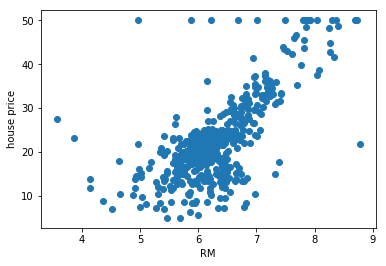

In [78]:
plt.scatter(X["RM"],y)
plt.xlabel("RM")
plt.ylabel("house price")
plt.show()

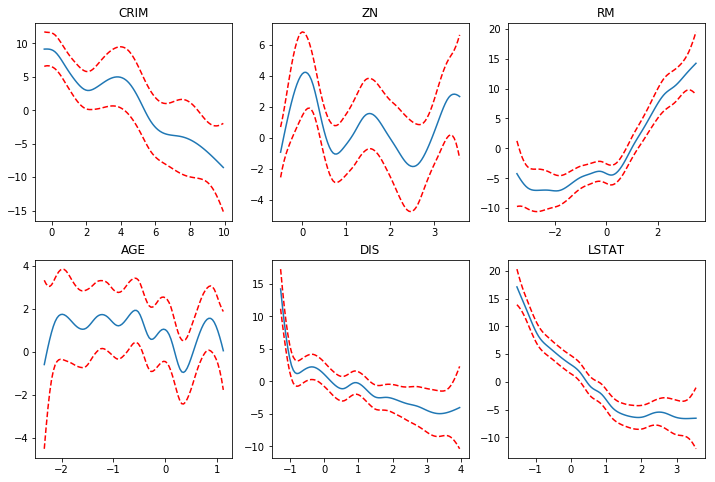

In [79]:
#外れ値を削除
ytmp=boston.target
ytmp=np.delete(ytmp,364)
df=df.drop(index=364)

#使用する変数を選択
X = df[['CRIM', 'ZN','RM', 'AGE', 'DIS', 'LSTAT']]
ss = preprocessing.StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X))
X_ss.columns=X.columns
#y = boston.target
y = ytmp

#trainとtestに分ける
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, 
                                                    test_size=0.3, random_state=42)

#GAMを適用
gam = LinearGAM().fit(X_train, y_train)

#それぞれのf(x)を図示
plt.figure(figsize=(12,8))
for i in range(X.shape[1]):
    plt.subplot(2,3,i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i],gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1],
                c='r', ls='--')
    plt.title(X.columns[i])
plt.show()